In [40]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import roc_auc_score
#from sklearn.feature_selection import RFE
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer

from lightgbm import LGBMClassifier
#import lightgbm as lgb

import time
from datetime import timedelta


# FUNCTIONS

In [41]:
def plot_feature_importances(df, threshold = 0.9):
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (25, 18))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:25]))), 
            df['importance_normalized'].head(25), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:25]))))
    ax.set_yticklabels(df['feature'].head(25))
    
    # Plot labeling
    plt.xlabel('Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df


In [42]:
# Normalization and fill missing values

def imput_scale(train_features, train_target, test_dataset):
    # Copy of the testing data
    test = train_features.copy()

    # Median imputation of missing values
    imputer = Imputer(strategy = 'median')

    # Scale each feature to unit scale (mean = 0 and variance = 1)
    scaler = MinMaxScaler(feature_range = (0, 1))

    # Fit on the training data
    imputer.fit(train_features)

    # Transform both training and testing data
    train = imputer.transform(train_features)
    test = imputer.transform(test_dataset)

    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    
    return train, test

# LOAD DATASET

In [43]:
# Load bureau_data_feat
app_train = pd.read_csv('/home/convidado/Denise/15_07/app_train_feat.csv')
app_train = app_train.drop(columns= ["Unnamed: 0"])

app_test = pd.read_csv('/home/convidado/Denise/15_07/app_test_feat.csv')
app_test = app_test.drop(columns= ["Unnamed: 0"])

print('Training data shape: ', app_train.shape)
app_train.head()

print('Test data shape: ', app_test.shape)

Training data shape:  (307511, 245)
Test data shape:  (48744, 244)


# Get the target and the features

In [44]:
app_train_target = app_train["TARGET"]

app_train = app_train.drop(columns = ['TARGET'])

# Print out the new shapes
print('Training final dataset shape: ', app_train.shape)
print('Training final target shape:  ', app_train_target.shape)
print('Testfinal dataset shape:  ', app_test.shape)

Training final dataset shape:  (307511, 244)
Training final target shape:   (307511,)
Testfinal dataset shape:   (48744, 244)


# ADD BUREAU_DATA_FEAT

In [45]:
# Load bureau_data_feat
bureau_data = pd.read_csv('/home/convidado/Denise/15_07/bureau_agg.csv')
bureau_data = bureau_data.drop(columns= ["Unnamed: 0"])
print('Training data shape: ', bureau_data.shape)
bureau_data.head()

Training data shape:  (305811, 244)


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_STATUS_X_min,bureau_STATUS_X_sum,bureau_STATUS_nan_count,bureau_STATUS_nan_mean,bureau_STATUS_nan_max,bureau_STATUS_nan_min,bureau_STATUS_nan_sum,bureau_DEBT_CREDIT_RATIO,bureau_OVERDUE_DEBIT_RATIO,DAYS_DIFF
0,100001,172,-1009.284884,-49,-1572,-173597,172,0.0,0,0,...,0,30.0,172,0.0,0,0,0,0.147934,0.0,0.0
1,100002,110,-996.781818,-103,-1437,-109646,110,0.0,0,0,...,0,15.0,110,0.0,0,0,0,0.320947,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,0,0.0,4,1.0,1,1,4,0.000000,NaN,515.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,0,0.0,2,1.0,1,1,2,0.000000,NaN,459.0
4,100005,21,-272.380952,-62,-373,-5720,21,0.0,0,0,...,0,2.0,21,0.0,0,0,0,0.755662,0.0,0.0


In [46]:
# Fill inf columns
bureau_data = bureau_data.replace(np.inf,0)
bureau_data = bureau_data.replace(-np.inf,0)

In [47]:
# Merge datasets

app_train_bureau = app_train.merge(bureau_data, on = ["SK_ID_CURR"], how = "left")
app_test_bureau = app_test.merge(bureau_data, on = ["SK_ID_CURR"], how = "left")

print('Training data new shape: ', app_train_bureau.shape)

print('Training data new shape: ', app_test_bureau.shape)

Training data new shape:  (307511, 487)
Training data new shape:  (48744, 487)


In [48]:
# Normalization and fill missing values

train, test = imput_scale(app_train_bureau, app_train_target, app_test_bureau)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 487)
Testing data shape:  (48744, 487)


In [49]:
# Light Gradient Boosting Descendent

#d_train = lgb.Dataset(train, label=app_train_target)

lg = LGBMClassifier(n_estimators=200,
    learning_rate=0.1,
    num_leaves=123,
    colsample_bytree=0.8,
    subsample=0.9,
    max_depth=15,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_split_gain=0.01,
    min_child_weight=2 )

lg.fit(train,app_train_target)

#Prediction
y_pred = lg.predict(train)

#convert into binary values
for i in range(0,99):
    if y_pred[i] >= .5:  
        y_pred[i]=1
    else:
        y_pred[i]=0
        
accuracy = accuracy_score(y_pred,app_train_target)
print(accuracy)

0.9324902198620537


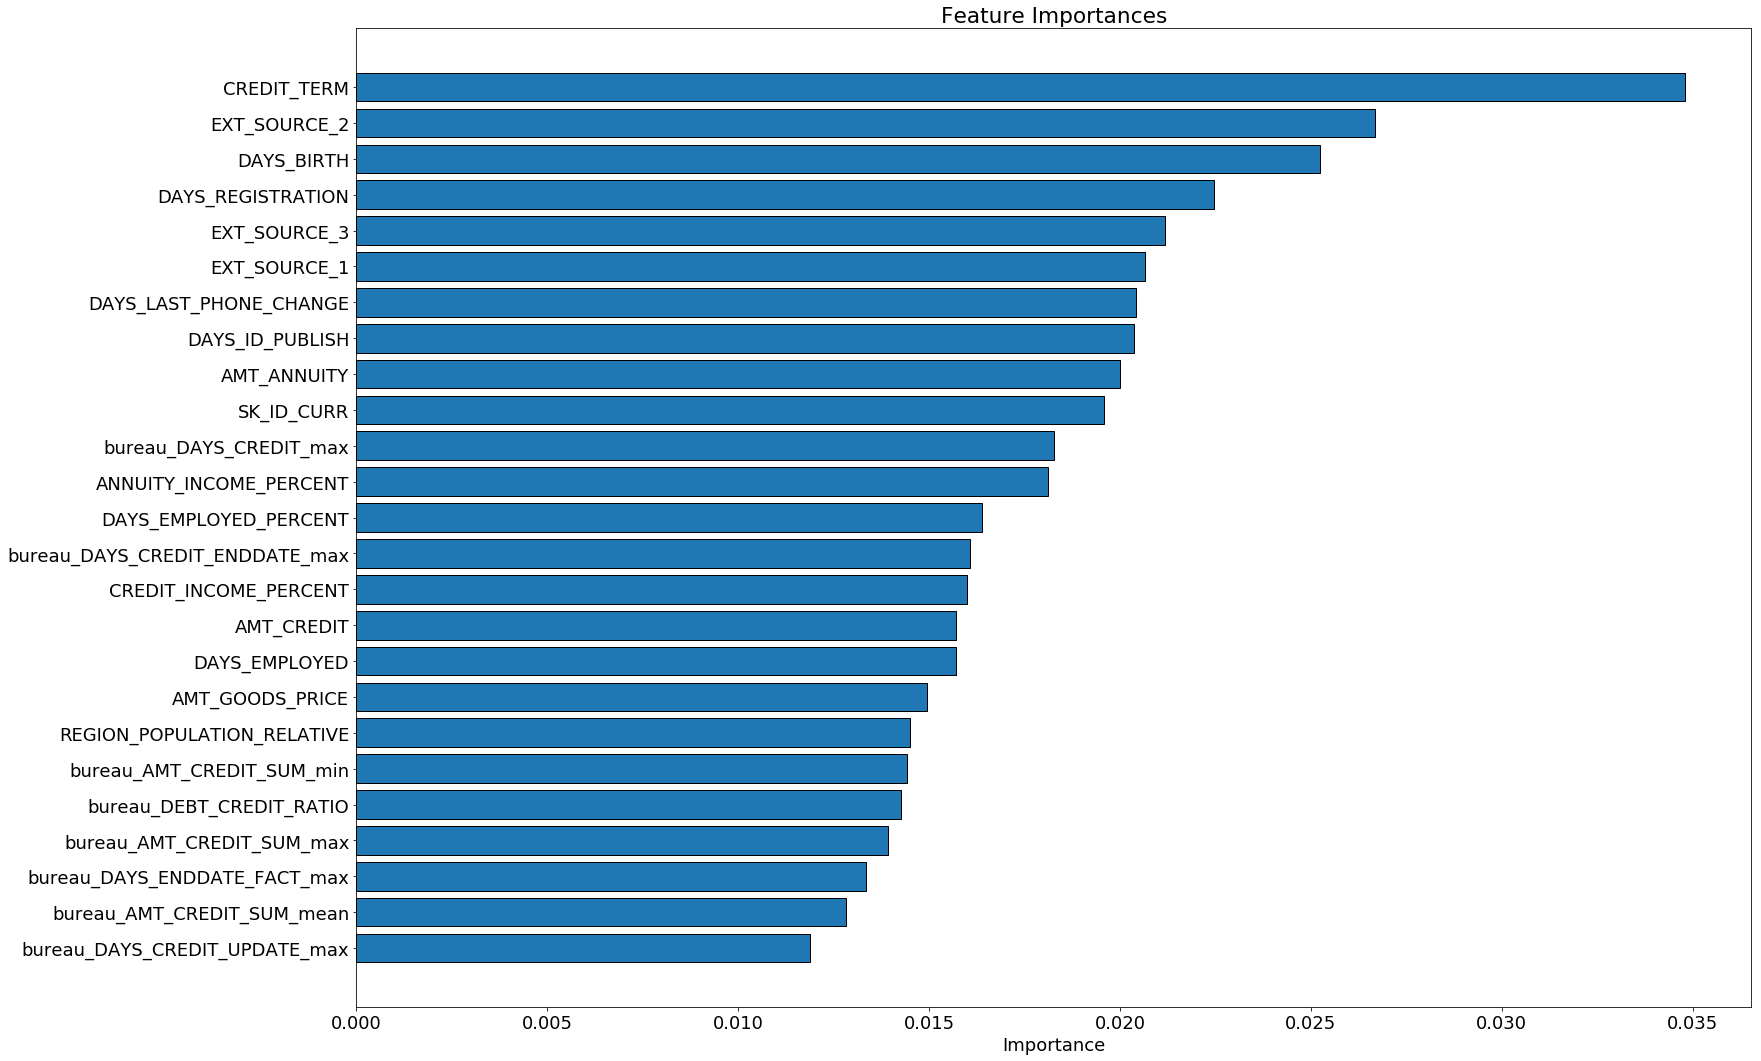

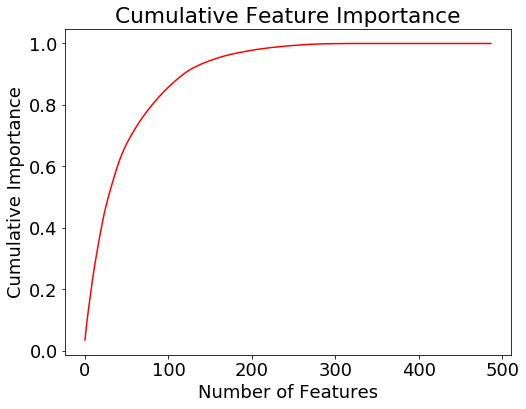

119 features required for 0.90 of cumulative importance


In [50]:
# Get the 15 features more important
feature_importances = lg.feature_importances_

feature_importances = pd.DataFrame({'feature': list(app_train_bureau.columns), 'importance': \
                                    feature_importances}).sort_values('importance', ascending = False)

norm_feature_importances = plot_feature_importances(feature_importances)

In [51]:
# Get the features with zero importance

zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])

print('There are %d features with 0.0 importance' % len(zero_features))

feature_importances[feature_importances['importance'] == 0.0]['feature'].head()

There are 174 features with 0.0 importance


197                   ORGANIZATION_TYPE_Mobile
192                ORGANIZATION_TYPE_Insurance
202                 ORGANIZATION_TYPE_Religion
422            bureau_CREDIT_TYPE_Mortgage_min
428    bureau_CREDIT_TYPE_Real estate loan_sum
Name: feature, dtype: object

In [52]:
# Drop features with zero importance
app_train_bureau_drop = app_train_bureau.drop(columns = zero_features)
app_test_bureau_drop = app_test_bureau.drop(columns = zero_features)

app_train_bureau_drop.shape

(307511, 313)

In [53]:
del app_train_bureau, app_test_bureau

# ADD PREVIOUS_APP

In [54]:
# Load previous_app_feat
previous_app_feat = pd.read_csv('/home/convidado/Denise/15_07/previous_app_feat_agg.csv')
previous_app_feat = previous_app_feat.drop(columns= ["Unnamed: 0"])
print('Training data shape: ', previous_app_feat.shape)
previous_app_feat.head()

Training data shape:  (338857, 395)


,SK_ID_CURR,previous_app_AMT_ANNUITY_count,previous_app_AMT_ANNUITY_mean,previous_app_AMT_ANNUITY_max,previous_app_AMT_ANNUITY_min,previous_app_AMT_ANNUITY_sum,previous_app_AMT_APPLICATION_count,previous_app_AMT_APPLICATION_mean,previous_app_AMT_APPLICATION_max,previous_app_AMT_APPLICATION_min,...,cc_balance_NAME_CONTRACT_STATUS_Signed_min,cc_balance_NAME_CONTRACT_STATUS_Signed_sum,cc_balance_NAME_CONTRACT_STATUS_nan_count,cc_balance_NAME_CONTRACT_STATUS_nan_mean,cc_balance_NAME_CONTRACT_STATUS_nan_max,cc_balance_NAME_CONTRACT_STATUS_nan_min,cc_balance_NAME_CONTRACT_STATUS_nan_sum,RATIO_PAYMENT_INSTALL_MIN,RATIO_PAY_CURR_PAY_TOTAL,RATIO_RECEIVABLE_TOTAL_RECEIVABLE
0,100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.50,24835.5,24835.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.00,179055.0,179055.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,3,56553.990,98356.995,6737.310,169661.970,3,435436.50,900000.0,68809.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,1,5357.250,5357.250,5357.250,5357.250,1,24282.00,24282.0,24282.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,1,4813.200,4813.200,4813.200,4813.200,2,22308.75,44617.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Merge datasets
app_train_previous = app_train_bureau_drop.merge(previous_app_feat, on = ["SK_ID_CURR"], how = "left")
app_test_previous = app_test_bureau_drop.merge(previous_app_feat, on = ["SK_ID_CURR"], how = "left")

print('Training data new shape: ', app_train_previous.shape)

print('Test data new shape: ', app_test_previous.shape)

Training data new shape:  (307511, 707)
Test data new shape:  (48744, 707)


In [56]:
del app_train_bureau_drop, app_test_bureau_drop

# ADD INSTALLMENTS

In [57]:
# Load previous_app_feat
installments_feat = pd.read_csv('/home/convidado/Denise/15_07/installments_agg.csv')
installments_feat = installments_feat.drop(columns= ["Unnamed: 0"])
print('Training data shape: ', installments_feat.shape)
installments_feat.head()

Training data shape:  (339587, 33)


,SK_ID_CURR,installments_payment_NUM_INSTALMENT_VERSION_count,installments_payment_NUM_INSTALMENT_VERSION_mean,installments_payment_NUM_INSTALMENT_VERSION_max,installments_payment_NUM_INSTALMENT_VERSION_min,installments_payment_NUM_INSTALMENT_VERSION_sum,installments_payment_NUM_INSTALMENT_NUMBER_count,installments_payment_NUM_INSTALMENT_NUMBER_mean,installments_payment_NUM_INSTALMENT_NUMBER_max,installments_payment_NUM_INSTALMENT_NUMBER_min,...,installments_payment_AMT_INSTALMENT_max,installments_payment_AMT_INSTALMENT_min,installments_payment_AMT_INSTALMENT_sum,installments_payment_AMT_PAYMENT_count,installments_payment_AMT_PAYMENT_mean,installments_payment_AMT_PAYMENT_max,installments_payment_AMT_PAYMENT_min,installments_payment_AMT_PAYMENT_sum,installments_payments_PAYMENT_INSTALMENT_RATIO,installments_payments_MEDIAN_DIFF_PAYMENTS_INSTALLMENT
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,17397.900,3951.000,41195.925,7,5885.132143,17397.900,3951.000,41195.925,1.0,-6.0
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,53093.745,9251.775,219625.695,19,11559.247105,53093.745,9251.775,219625.695,1.0,-19.0
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,560835.360,6662.970,1618864.650,25,64754.586000,560835.360,6662.970,1618864.650,1.0,-6.0
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,10573.965,5357.250,21288.465,3,7096.155000,10573.965,5357.250,21288.465,1.0,-9.0
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,17656.245,4813.200,56161.845,9,6240.205000,17656.245,4813.200,56161.845,1.0,-29.0


In [58]:
# Merge datasets
app_train_previous = app_train_previous.merge(installments_feat, on = ["SK_ID_CURR"], how = "left")
app_test_previous = app_test_previous.merge(installments_feat, on = ["SK_ID_CURR"], how = "left")

print('Training data new shape: ', app_train_previous.shape)

print('Test data new shape: ', app_test_previous.shape)

Training data new shape:  (307511, 739)
Test data new shape:  (48744, 739)


In [59]:
# Fill inf columns
app_train_previous = app_train_previous.replace(np.inf,0)
app_test_previous = app_test_previous.replace(-np.inf,0)

In [60]:
del installments_feat

In [61]:
# Normalization and fill missing values

train, test = imput_scale(app_train_previous, app_train_target, app_test_previous)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 739)
Testing data shape:  (48744, 739)


In [62]:
# Light Gradient Boosting Descendent

#d_train = lgb.Dataset(train, label=app_train_target)

lg = LGBMClassifier(n_estimators=200,
    learning_rate=0.1,
    num_leaves=123,
    colsample_bytree=0.8,
    subsample=0.9,
    max_depth=15,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_split_gain=0.01,
    min_child_weight=2 )

lg.fit(train,app_train_target)

#Prediction
y_pred = lg.predict(train)

#convert into binary values
for i in range(0,99):
    if y_pred[i] >= .5:  
        y_pred[i]=1
    else:
        y_pred[i]=0
        
accuracy = accuracy_score(y_pred,app_train_target)
print(accuracy)

0.9375436976238248


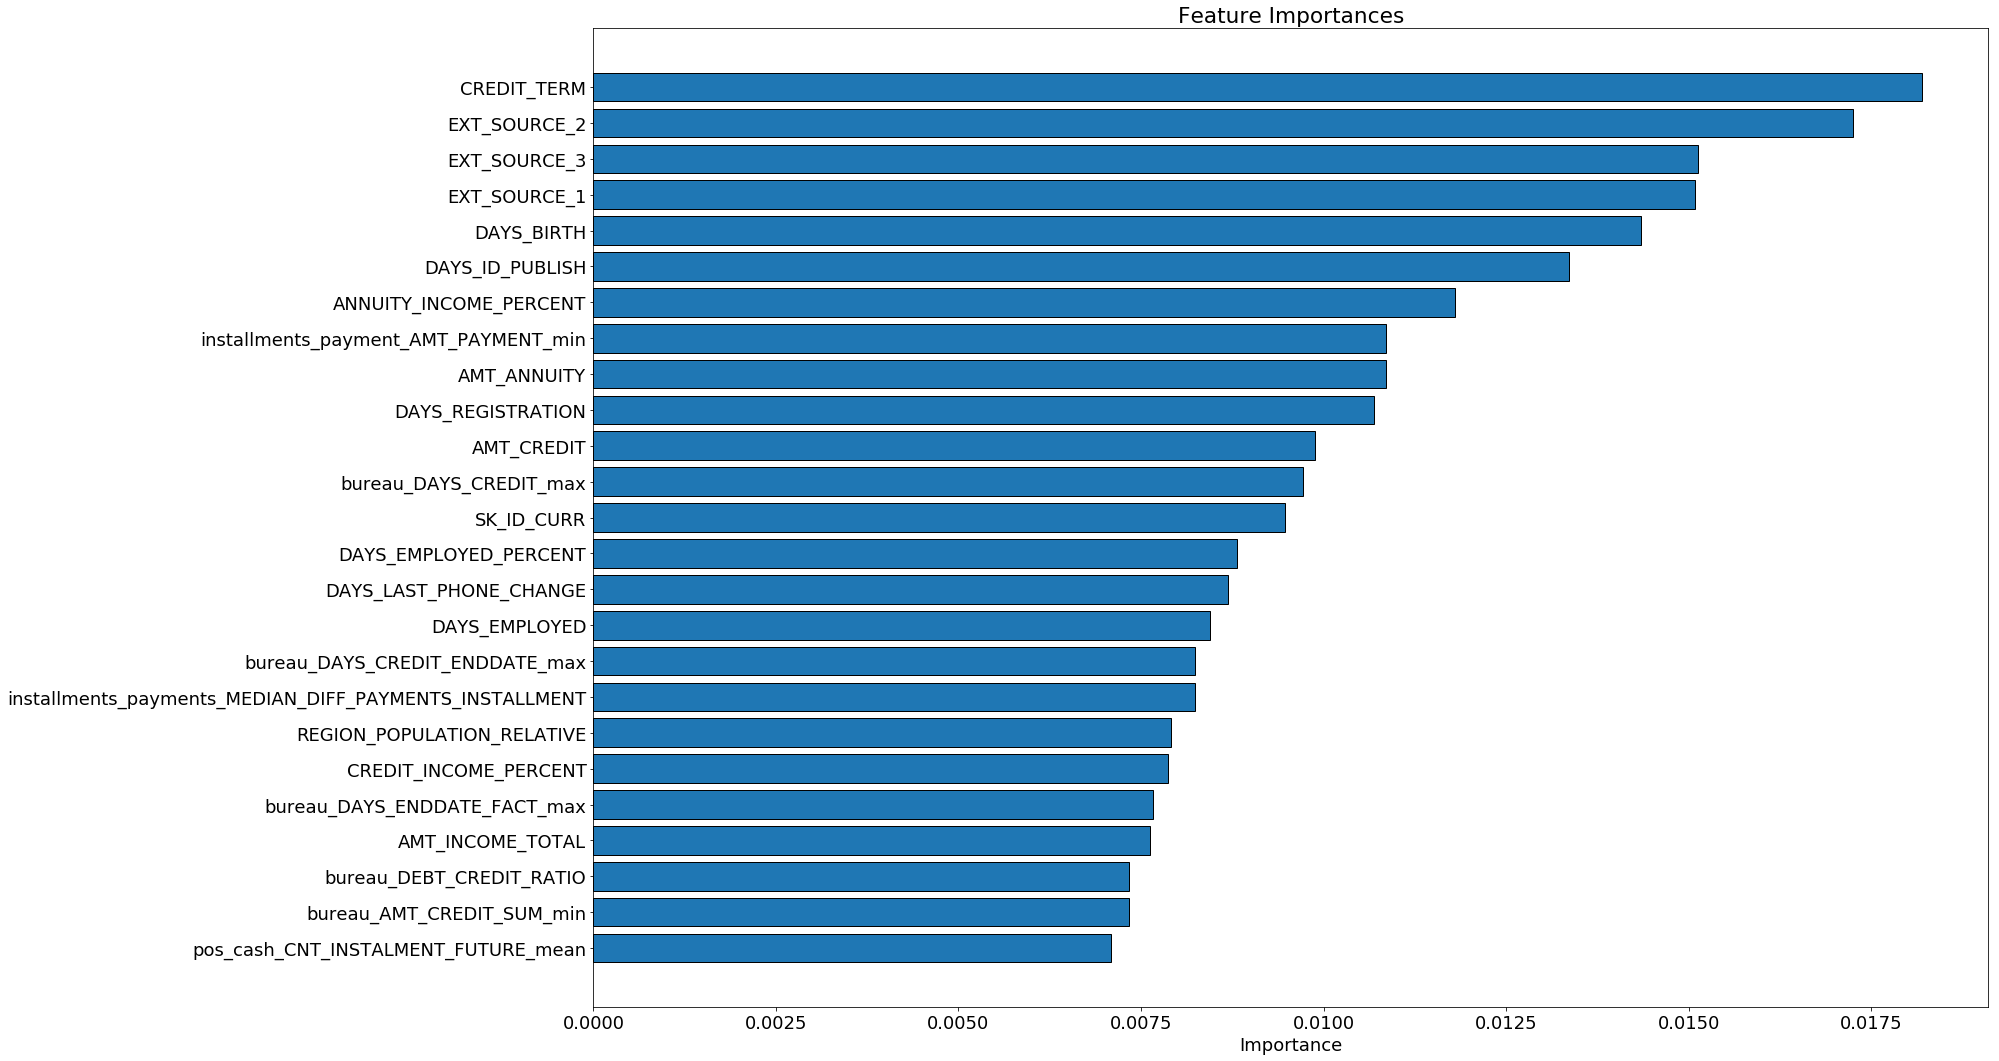

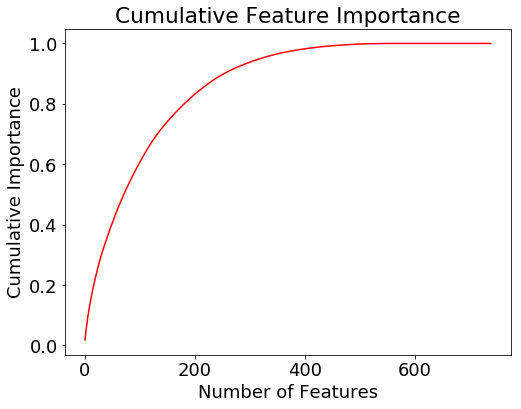

254 features required for 0.90 of cumulative importance


In [63]:
# Get the 15 features more important
feature_importances = lg.feature_importances_

feature_importances = pd.DataFrame({'feature': list(app_train_previous.columns), 'importance': \
                                    feature_importances}).sort_values('importance', ascending = False)

norm_feature_importances = plot_feature_importances(feature_importances)

In [64]:
# Normalized final dataframes

train_final = pd.DataFrame(data = train, columns = app_train_previous.columns)
train_final["SK_ID_CURR"] = app_train_previous[["SK_ID_CURR"]]


test_final = pd.DataFrame(data = test, columns = app_test_previous.columns)
test_final["SK_ID_CURR"] = app_test_previous[["SK_ID_CURR"]]

#app_train_target -> final targets

train_final.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,installments_payment_AMT_INSTALMENT_max,installments_payment_AMT_INSTALMENT_min,installments_payment_AMT_INSTALMENT_sum,installments_payment_AMT_PAYMENT_count,installments_payment_AMT_PAYMENT_mean,installments_payment_AMT_PAYMENT_max,installments_payment_AMT_PAYMENT_min,installments_payment_AMT_PAYMENT_sum,installments_payments_PAYMENT_INSTALMENT_RATIO,installments_payments_MEDIAN_DIFF_PAYMENTS_INSTALLMENT
0,100002,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,...,0.014078,0.003694,0.009436,0.051075,0.004615,0.014078,3.693928e-03,0.008600,0.321679,0.118994
1,100003,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,...,0.148704,0.002660,0.069555,0.067204,0.025854,0.148704,2.660304e-03,0.063393,0.321679,0.124310
2,100004,1.0,1.0,1.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,...,0.002804,0.002139,0.000915,0.008065,0.002833,0.002804,2.138973e-03,0.000834,0.321679,0.123083
3,100006,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,...,0.183425,0.000991,0.043272,0.043011,0.025133,0.183425,9.913480e-04,0.039439,0.321679,0.124310
4,100007,0.0,0.0,1.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,...,0.006013,0.000727,0.035918,0.177419,0.004877,0.006013,7.186806e-08,0.031567,0.321679,0.125946


In [65]:
# Get the final features with cumulative importance >= 0.99

# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()
    
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['importance_normalized'])

feature_importances.head()

,feature,importance,importance_normalized,cumulative_importance
200,CREDIT_TERM,444,0.018197,0.018197
30,EXT_SOURCE_2,421,0.017254,0.035451
31,EXT_SOURCE_3,369,0.015123,0.050574
29,EXT_SOURCE_1,368,0.015082,0.065656
10,DAYS_BIRTH,350,0.014344,0.080000


In [66]:
# Get the index and the final features

importance_index = np.min(np.where(feature_importances['cumulative_importance'] > 0.99))

importance_index

feature_final = list(feature_importances[:435]["feature"])

feature_final

['CREDIT_TERM',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'ANNUITY_INCOME_PERCENT',
 'installments_payment_AMT_PAYMENT_min',
 'AMT_ANNUITY',
 'DAYS_REGISTRATION',
 'AMT_CREDIT',
 'bureau_DAYS_CREDIT_max',
 'SK_ID_CURR',
 'DAYS_EMPLOYED_PERCENT',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_EMPLOYED',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'installments_payments_MEDIAN_DIFF_PAYMENTS_INSTALLMENT',
 'REGION_POPULATION_RELATIVE',
 'CREDIT_INCOME_PERCENT',
 'bureau_DAYS_ENDDATE_FACT_max',
 'AMT_INCOME_TOTAL',
 'bureau_AMT_CREDIT_SUM_min',
 'bureau_DEBT_CREDIT_RATIO',
 'pos_cash_CNT_INSTALMENT_FUTURE_mean',
 'bureau_AMT_CREDIT_SUM_mean',
 'AMT_GOODS_PRICE',
 'installments_payment_DAYS_ENTRY_PAYMENT_max',
 'previous_app_CNT_PAYMENT_mean',
 'bureau_AMT_CREDIT_SUM_max',
 'previous_app_AMT_ANNUITY_min',
 'installments_payment_AMT_PAYMENT_sum',
 'previous_app_AMT_GOODS_PRICE_min',
 'previous_app_DAYS_DECISION_max',
 'installments_payment_AMT_INSTALMENT_mean',
 'inst

# Final datasets

In [68]:
# Get the final datasets

train_final = train_final[feature_final]
test_final = test_final[feature_final]

train_final.head()

,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,DAYS_ID_PUBLISH,ANNUITY_INCOME_PERCENT,installments_payment_AMT_PAYMENT_min,AMT_ANNUITY,DAYS_REGISTRATION,...,FLAG_DOCUMENT_13,bureau_CREDIT_ACTIVE_Sold_sum,OCCUPATION_TYPE_Waiters/barmen staff,previous_app_AMT_CREDIT_count,NAME_TYPE_SUITE_Other_B,WEEKDAY_APPR_PROCESS_START_FRIDAY,cc_balance_CNT_DRAWINGS_OTHER_CURRENT_max,NAME_EDUCATION_TYPE_Lower secondary,cc_balance_AMT_INST_MIN_REGULARITY_min,previous_app_NAME_CLIENT_TYPE_New_sum
0,0.377861,0.307542,0.155054,0.072215,0.888839,0.705433,0.064910,3.693928e-03,0.090032,0.852140,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.038462
1,0.053985,0.727773,0.597163,0.312933,0.477114,0.959566,0.070368,2.660304e-03,0.132924,0.951929,...,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.272843,0.650190,0.814130,0.518318,0.348534,0.648326,0.053193,2.138973e-03,0.020025,0.827335,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.038462
3,0.711908,0.760751,0.597163,0.518318,0.350846,0.661387,0.117114,9.913480e-04,0.109477,0.601451,...,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.038462
4,0.200770,0.377472,0.597163,0.518318,0.298591,0.519522,0.095823,7.186806e-08,0.078975,0.825268,...,0.0,0.0,0.0,0.069444,0.0,0.0,0.0,0.0,0.0,0.038462


In [33]:
# Sample 16000 rows (16000 for training, 4000 for testing)
#train_final["TARGET"] = app_train_target

# Hyperparameter tuning

In [72]:
# Modeling
import lightgbm as lgb
import random

random.seed(50)

N_FOLDS = 5
MAX_EVALS = 3


In [73]:
def objective(hyperparameters, iteration, dataset):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, dataset, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [74]:
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

# Random search

In [75]:
# Dataframe for random search
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

In [76]:
def random_search(param_grid, dataset, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        print("STATUS >>>>>>>> EVAL: " + str(i))
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i, dataset)
        
        results.loc[i, :] = eval_results
        print("\nAC = " + str(eval_results[0]))
        
        print("Parameters: ")
        print(eval_results[1])
        print("-------------------------------------------------")
        
        # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

# Test in the entire set

In [78]:
# Create a training and testing dataset
train_final_set = lgb.Dataset(data = train_final, label = app_train_target)

In [79]:
start_time = time.time()

random_results = random_search(param_grid = param_grid, dataset = train_final_set)

print('\nThe best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

elapsed_time_secs = time.time() - start_time

msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))

STATUS >>>>>>>> EVAL: 0


KeyboardInterrupt: 

In [80]:
# Light Gradient Boosting Descendent with hyperparameter tuning


start_time = time.time()

lg_hyper = LGBMClassifier(boosting_type = 'gbdt', colsample_bytree = 0.6888888888888889, is_unbalance = True, \
                          learning_rate = 0.0062671213273069961, metric =  'auc', min_child_samples = 350, \
                          n_estimators = 4954, num_leaves = 37, reg_alpha = 0.26530612244897955, \
                          reg_lambda = 0.6938775510204082, \
                          subsample = 0.9545454545454546, subsample_for_bin = 180000, verbose = 1)

lg_hyper.fit(train_final ,app_train_target)

#Prediction
y_pred_hyper = lg_hyper.predict(train_final)

#convert into binary values
for i in range(0,99):
    if y_pred_hyper[i] >= .5:  
        y_pred_hyper[i]=1
    else:
        y_pred_hyper[i]=0
        
accuracy = accuracy_score(y_pred_hyper,app_train_target)
auc = roc_auc_score(app_train_target, y_pred_hyper)

print("Accuracy: ")
print(accuracy)

print("UAC: ")
print(auc)

elapsed_time_secs = time.time() - start_time

msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))

print(msg)    

Accuracy: 
0.7871198103482477
UAC: 
0.8096395964880102
Execution took: 0:10:50 secs (Wall clock time)


# SUBMISSION

In [81]:
# Get the submission
proba_grad = lg_hyper.predict_proba(test_final)[:, 1]

submit_grad = app_test_previous[['SK_ID_CURR']]
submit_grad['TARGET'] = proba_grad

submit_grad.head()

,SK_ID_CURR,TARGET
0,100001,0.223004
1,100005,0.542998
2,100013,0.082859
3,100028,0.179729
4,100038,0.635850


In [182]:
# Save the submission to a csv file
submit_grad.to_csv('/home/convidado/Denise/15_07/20_07_random_seach_lgbm_99importances.cv', index = False)
